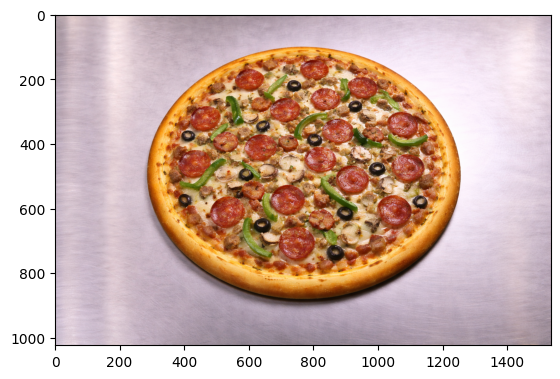

In [259]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.morphology import binary_closing, binary_opening, disk
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.color import gray2rgb
from skimage.color import rgb2hsv


#Leitura da imagem
img_color = imread("pizzaG1.png")
plt.imshow(img_color)

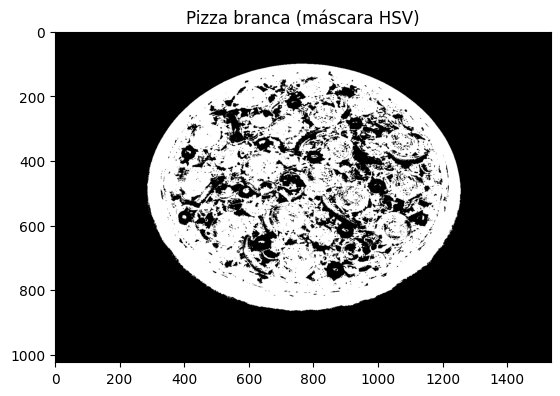

In [260]:
# Conversão para HSV para facilitar a segmentação da pizza,
# explorando a alta saturação em relação ao fundo metálico
hsv = rgb2hsv(img_color)
H, S, V = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]

mask = (S > 0.4) & (V > 0.5)

plt.imshow(mask, cmap="gray")
plt.title("Pizza branca (máscara HSV)")
plt.show()


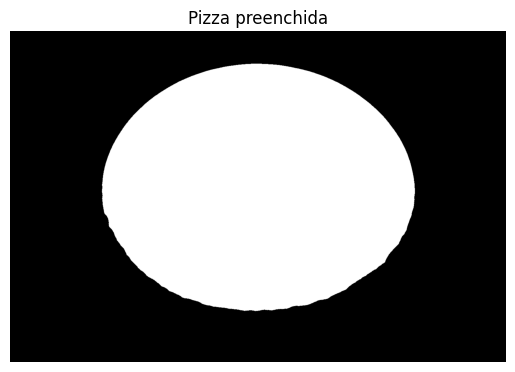

In [261]:
# 1 Fechamento forte → fecha recheio
step1 = binary_closing(mask, disk(30))

# 2 Abertura leve → remove sujeira colada
step2 = binary_opening(step1, disk(5))

# 3 Fechamento médio → regulariza a borda
filled = binary_closing(step2, disk(10))

plt.imshow(filled, cmap="gray")
plt.title("Pizza preenchida")
plt.axis("off")
plt.show()


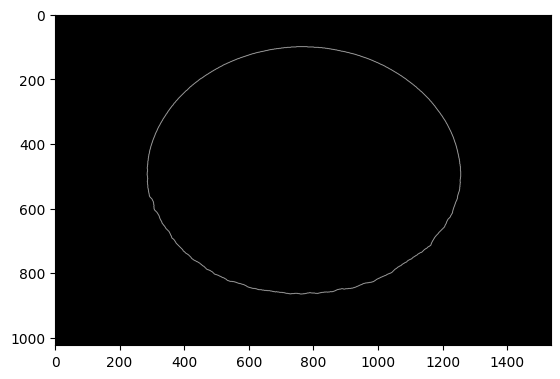

In [262]:
# 2) Passa-alta (Sobel)
edges = sobel(filled)
plt.imshow(edges,cmap="gray")

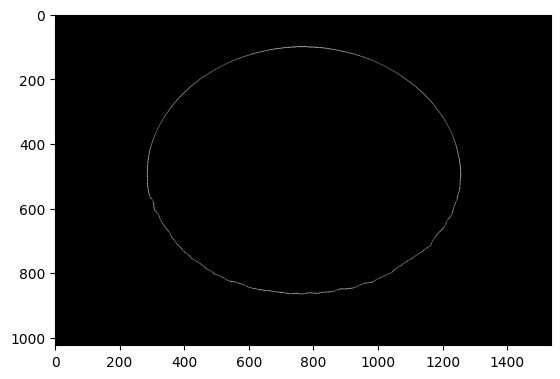

In [263]:
# 3) Binarização
limiar = edges.max() * (209/256)
binary = edges.copy()
binary[binary <= limiar] = 0
binary[binary > 0] = 1

plt.imshow(binary,cmap="gray")

Pizza grande


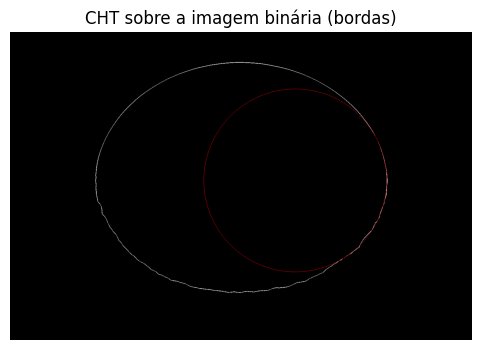

In [264]:

#  converte para uint8
binary_cht = (binary > 0).astype(np.uint8)


# faixa de raios
radii = np.arange(100, 380, 3)


# CHT
hough_res = hough_circle(binary_cht, radii)
accums, cx, cy, radii_detected = hough_circle_peaks(
    hough_res,
    radii,
    total_num_peaks=1,
    min_xdistance=150,
    min_ydistance=150
)
r = (np.min(radii_detected) + np.max(radii_detected)) / 2


#Classificação de raios
if r < 190:
    print("Pizza pequena")
elif r < 300:
    print("Pizza média")
else:
    print("Pizza grande")


#plot de um esboço

binary_rgb = gray2rgb(binary_cht * 255)
fig, ax = plt.subplots(figsize=(10,4))

for y, x, r in zip(cy, cx, radii_detected):
    rr, cc = circle_perimeter(y, x, int(r), shape=binary_cht.shape)
    binary_rgb[rr, cc] = (255, 0, 0)   # vermelho

ax.imshow(binary_rgb)
ax.set_title("CHT sobre a imagem binária (bordas)")
ax.axis("off")
plt.show()




